# Data Preparation 



## Packages

In [1]:
import os
import glob
import seedbank
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts
from colossus.lss import peaks
import matplotlib.pyplot as plt
from collections import Counter
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_dk14, profile_einasto

## Loading data

### Radial bins

Variable definition of the radial bins data set:

`r_min`: lower edge of the radial bin

`r_mid`: middle of the radial bin. We adopt `r_mid` in our modeling process as the distance to the halo center.

`r_max`: upper edge of the radial bin


In [2]:
radial_bins_3d = pd.read_table("rhoLb1050/radial_bins_3d.dat", sep="\s+", skiprows=[1,2])
radial_bins_3d

,"r_min,","r_max,",r_mid
0,0.047547,0.059858,0.053348
1,0.059858,0.075357,0.067162
2,0.075357,0.094868,0.084552
3,0.094868,0.119432,0.106444
4,0.119432,0.150356,0.134005
5,0.150356,0.189287,0.168702
6,0.189287,0.238298,0.212384
7,0.238298,0.300000,0.267375
8,0.300000,0.377678,0.336606
9,0.377678,0.475468,0.423761


### `rho_z` and `rockstar` data

Getting the list of data files for `rho_z` and `rockstar` data.

Note: The data was generated from two simulation boxes, shown below. We can view every halo in a single box, but there is usually some contamination at the edge of these boxes. Hence we eliminate halos from the redshift range 0.33 to 0.37.

Box `Lb1050` $\implies z < 0.32$

Box `Lb2600` $\implies z > 0.32$

In the code below, we load the file names of the data we will be needing.


In [3]:
#Bin 1050
rho_1050 = sorted(glob.glob("rhoLb1050/rho*"))
rockstar_1050 = sorted(glob.glob("rhoLb1050/rock*"))
rho_1050 = rho_1050[0:14] + rho_1050[17:18] #files for redshifts 0.33 to 0.37 are corrupted due to the contamination. 
rockstar_1050 = rockstar_1050[0:14] + rockstar_1050[21:22]
del rho_1050[-2] #eliminating the redshift bin 0.32 to 0.33.
del rockstar_1050[-2]

#Bin 2600
rho_2600 = sorted(glob.glob("rhoLb2600/rho*"))
rockstar_2600 = sorted(glob.glob("rhoLb2600/rock*"))
rockstar_2600 = rockstar_2600[14:]
rockstar_2600.remove("rhoLb2600/rockstar_rs_z_0.3_0.31.dat")
del rho_2600[:5] #eliminating the redshift bins from 0.32 to 0.37.
del rockstar_2600[:5]

rho_z = rho_1050 + rho_2600
rockstar_rs_z = rockstar_1050 + rockstar_2600


Loading `rho_z` data

For each halo, the `rho_z` data set contains 20 different density values at each of the radial bins above. The first column contains the halo IDs.

In [4]:
names = list(range(21))
rho_z_data = pd.DataFrame(columns=names)

for datafile in rho_z:
    rho = pd.read_table(datafile, sep="\s+", header=None, skiprows=[0])
    rho_z_data = pd.concat([rho_z_data, rho], axis=0)
rho_z_data = rho_z_data.reset_index().drop(columns=["index",1,2])
rho_z_data.head()

,0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,4885861,7.099450e+15,4.681780e+15,3.998350e+15,2.935320e+15,2.150140e+15,1.495910e+15,9.866110e+14,6.701850e+14,4.420990e+14,2.807700e+14,1.777850e+14,1.137860e+14,6.712720e+13,4.330540e+13,2.107700e+13,9.337020e+12,5.147430e+12,3.314120e+12
1,9784661,3.886010e+15,3.258520e+15,1.914700e+15,1.975700e+15,1.570170e+15,1.056350e+15,7.331480e+14,5.099110e+14,3.388640e+14,2.370820e+14,1.711340e+14,1.122880e+14,6.138310e+13,3.301300e+13,1.771500e+13,1.147340e+13,6.856530e+12,2.345350e+12
2,10066287,3.736550e+15,3.595610e+15,2.252590e+15,1.975700e+15,1.423990e+15,9.358290e+14,6.277360e+14,4.713260e+14,3.186330e+14,2.215750e+14,1.367580e+14,8.783020e+13,6.357940e+13,3.485690e+13,2.019050e+13,1.085890e+13,5.372470e+12,1.535670e+12
3,12390043,6.725790e+15,4.831600e+15,3.604150e+15,2.577810e+15,1.466430e+15,9.358290e+14,5.673310e+14,3.585400e+14,2.195620e+14,1.410560e+14,8.384820e+13,5.550720e+13,3.487760e+13,2.273930e+13,1.572050e+13,1.301180e+13,4.127660e+12,1.119550e+12
4,5486940,5.455370e+15,3.745420e+15,2.703110e+15,2.304980e+15,1.589030e+15,1.053990e+15,6.999850e+14,5.164410e+14,3.010800e+14,1.878760e+14,1.197190e+14,7.809210e+13,5.199730e+13,2.855350e+13,1.258960e+13,5.889100e+12,3.929860e+12,1.697720e+12


Loading `rockstar` data


Variable definition of the `rockstar` data is given below:

`id`: unique identifier for each halo

`Mvir_Msun.h`: virial mass of the halo (measured in solar mass, $M_{\odot}/h$), where $h$ is the Hubble constant.

`z_orig`: original redshift

`Rvir_Mpc.h`: virial radius in megaparsecs ($Mpc/h$)

`pid`: parent ID. Halos with `pid = -1` are parent/host halos. For now, we are interested in only parent halos. Subhalos are difficult to handle due to dominant contributions from their host halos. As such, they cannot be modeled in isolation without accounting for these contributions.

`rs`: scale radius of the halo

We can obtain the concentration parameter using the equation $C_{vir}=\frac{Rvir_Mpc.h}{rs}$ for every single halo.



In [5]:
rockstar_data = pd.DataFrame(columns=["id", "Mvir_Msun.h", "z_orig", "Rvir_Mpc.h", "pid", "rs"])

for datafile in rockstar_rs_z:
    rockstar = pd.read_table(datafile, sep="\s+", skiprows=[1])
    rockstar.columns = ["id", "Mvir_Msun.h", "z_orig", "Rvir_Mpc.h", "pid", "rs"]
    rockstar_data = pd.concat([rockstar_data, rockstar], axis=0)

rockstar_data = rockstar_data.reset_index().drop(columns=["index"])
rockstar_data.head()

,id,Mvir_Msun.h,z_orig,Rvir_Mpc.h,pid,rs
0,4885861,1.083000e+15,0.182590,2.24837,-1,0.360575
1,9784661,9.987000e+14,0.183402,2.18886,-1,0.552047
2,10066287,9.211000e+14,0.183258,2.13058,-1,0.602310
3,12390043,6.790000e+14,0.189336,1.92786,-1,0.928506
4,5486940,6.694000e+14,0.188059,1.91804,-1,0.336492


We expect the halo ` id` to be the same across the different data sets. Here, we check to see if this condition is satisfied.

In [6]:
(rho_z_data[0] == rockstar_data["id"]).value_counts()

True    1501468
dtype: int64

Note: Here we notice that some halos have their parent id (pid) different from -1. Those halos will be removed from all the data sets.

In [7]:
print(any(rockstar_data[["pid"]] != -1))
print(rockstar_data[rockstar_data["pid"] != -1].shape)

True
(73999, 6)


Removing halos with `pid` different from -1 from the `rockstar` data.

In [8]:
rockstar_data1 = rockstar_data[rockstar_data["pid"] == -1]
rockstar_data1 = pd.DataFrame(rockstar_data1)
print(rockstar_data1.shape)
rockstar_data1.head()

(1427469, 6)


,id,Mvir_Msun.h,z_orig,Rvir_Mpc.h,pid,rs
0,4885861,1.083000e+15,0.182590,2.24837,-1,0.360575
1,9784661,9.987000e+14,0.183402,2.18886,-1,0.552047
2,10066287,9.211000e+14,0.183258,2.13058,-1,0.602310
3,12390043,6.790000e+14,0.189336,1.92786,-1,0.928506
4,5486940,6.694000e+14,0.188059,1.91804,-1,0.336492


Removing halos with `pid` different from -1 from the `rho_z` data. The `rho_z` data does not have the column `pid` so we use the indexes of the `rockstar` data above.

Next, we check again to make sure that the halo ids are still the same.


In [9]:
diff_pid = rockstar_data[rockstar_data["pid"] == -1]
rho_z_data1 = rho_z_data.iloc[diff_pid.index, :]
rho_z_data1 = pd.DataFrame(rho_z_data1)
print(rho_z_data1.shape)
rho_z_data1.head()

(1427469, 19)


,0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,4885861,7.099450e+15,4.681780e+15,3.998350e+15,2.935320e+15,2.150140e+15,1.495910e+15,9.866110e+14,6.701850e+14,4.420990e+14,2.807700e+14,1.777850e+14,1.137860e+14,6.712720e+13,4.330540e+13,2.107700e+13,9.337020e+12,5.147430e+12,3.314120e+12
1,9784661,3.886010e+15,3.258520e+15,1.914700e+15,1.975700e+15,1.570170e+15,1.056350e+15,7.331480e+14,5.099110e+14,3.388640e+14,2.370820e+14,1.711340e+14,1.122880e+14,6.138310e+13,3.301300e+13,1.771500e+13,1.147340e+13,6.856530e+12,2.345350e+12
2,10066287,3.736550e+15,3.595610e+15,2.252590e+15,1.975700e+15,1.423990e+15,9.358290e+14,6.277360e+14,4.713260e+14,3.186330e+14,2.215750e+14,1.367580e+14,8.783020e+13,6.357940e+13,3.485690e+13,2.019050e+13,1.085890e+13,5.372470e+12,1.535670e+12
3,12390043,6.725790e+15,4.831600e+15,3.604150e+15,2.577810e+15,1.466430e+15,9.358290e+14,5.673310e+14,3.585400e+14,2.195620e+14,1.410560e+14,8.384820e+13,5.550720e+13,3.487760e+13,2.273930e+13,1.572050e+13,1.301180e+13,4.127660e+12,1.119550e+12
4,5486940,5.455370e+15,3.745420e+15,2.703110e+15,2.304980e+15,1.589030e+15,1.053990e+15,6.999850e+14,5.164410e+14,3.010800e+14,1.878760e+14,1.197190e+14,7.809210e+13,5.199730e+13,2.855350e+13,1.258960e+13,5.889100e+12,3.929860e+12,1.697720e+12


In [10]:
(rho_z_data1[0]==rockstar_data1["id"]).value_counts()

True    1427469
dtype: int64

#### Converting from comoving to physical units
Our data is in comoving but the Colossus package in Python, which we will be using, calibrates densities in physical units. Hence, we convert our units to physical units to allow for easy comparison between Colossus and our machine learning models.


In [11]:
# rho_z_final2 = pd.DataFrame(rho_z_final1)
rho_z_final = rho_z_data1.reset_index().drop(columns=["index"])

rockstar_final = pd.DataFrame(rockstar_data1)
rockstar_final["Rvir_Mpc.h"] = rockstar_final["Rvir_Mpc.h"]/(1+rockstar_final["z_orig"]) #Rvir/(1+z) -- converting from comoving Rvir to physical Rvir
rockstar_final["rs"] = rockstar_final["rs"]/(1+rockstar_final["z_orig"]) #rs/(1+z) -- converting from comoving rs to physical rs
rockstar_final = rockstar_final.reset_index().drop(columns=["index"])


Checking if all halo ids in the two data sets match

In [12]:
(rho_z_final[0]==rockstar_final["id"]).value_counts()

True    1427469
dtype: int64

### Checking for Missing Values
Clearly there are no missing values in the two data sets.

In [13]:
print(rockstar_final.isnull().sum())
print()
print(rho_z_final.isnull().sum())

id             0
Mvir_Msun.h    0
z_orig         0
Rvir_Mpc.h     0
pid            0
rs             0
dtype: int64

0     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
dtype: int64


## Plot of density profiles

We plot `rho_z` for first five halos

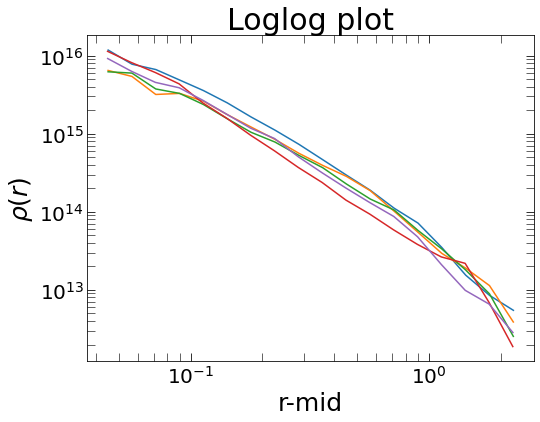

In [14]:
plt.figure(figsize=(8,6)) 
plt.rc("axes", labelsize=18) 
plt.title("Loglog plot", fontsize = 30)
plt.tick_params(axis="both", direction="in", length=8, which = "both", labelsize=20, top = True, right = True)
plt.xlabel(r"r-mid", fontsize = 25)
plt.ylabel(r"$\rho(r)$", fontsize = 25)
for i in range(5):
    plt.loglog()
    plt.plot(radial_bins_3d[["r_mid"]]/(1 + rockstar_final.loc[i][2]), 
             rho_z_final.iloc[i, 1:]*(1 + rockstar_final.loc[i][2])**3, "-")

Here, we plot the density profile of a single halo arbitrarily selected from the data. We also plot the slope of the density profile. 

In [15]:
row = 242548
Mvir = rockstar_final.iloc[row][1]
cvir = (rockstar_final.iloc[row][3])/(rockstar_final.iloc[0][5])
z = rockstar_final.iloc[row][2]
Rvir = rockstar_final.iloc[row][3]#/(1+z)
r = radial_bins_3d[["r_mid"]]/(1+z)

In [16]:
#Setting Cosmology.
params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.046, 'sigma8': 0.82, 'ns': 0.96}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

#Fitting DK14 profile with the outer term calibrated by a power law
p_dk14 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir, c = cvir, z = z, mdef = 'vir', 
                                                   outer_term_names = ['pl'])
#Fitting NFW profile
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

#Fitting Einasto profile
p_einasto = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

#Density profiles
rho_dk14 = p_dk14.density(r*1000) #DK14 predictions
rho_nfw = p_nfw.density(r*1000) #NFW predictions
rho_einasto = p_einasto.density(r*1000) #Einasto predictions

# Slope
rho_dk14_der = p_dk14.densityDerivativeLog(r["r_mid"]*1000)
rho_nfw_der = p_nfw.densityDerivativeLog(r*1000)
rho_einasto_der = p_einasto.densityDerivativeLog(r*1000)

In [17]:
def NFW_Profile(r, z, rhos = None, rs = None, Mvir = None, Cvir = None, Rvir = None):
    '''
    This function fits the NFW profile. 
    r: distance to halo center
    z: redshift
    rhos: scale density
    Mvir: virial mass
    Cvir: concentration parameter
    Rvir: virial radius
    
    In addition r and z, one must supply either of the following to the function.
    1. rhos and rs 
    2. Mvir, Cvir, and Rvir 
    '''
    if rhos is not None and rs is not None:
        density_nfw = rhos/((r/rs)*(1 + (r/rs))**2)
    elif Mvir is not None and Cvir is not None and Rvir is not None:
        Rx = Rvir
        rs = Rx/Cvir
        rhos = Mvir/(4*np.pi*rs**3*(np.log(1 + Cvir) - Cvir/(1+Cvir)))
        density_nfw = rhos/((r/rs)*(1 + (r/rs))**2)
    return rs, rhos, density_nfw#/(1+z)**3

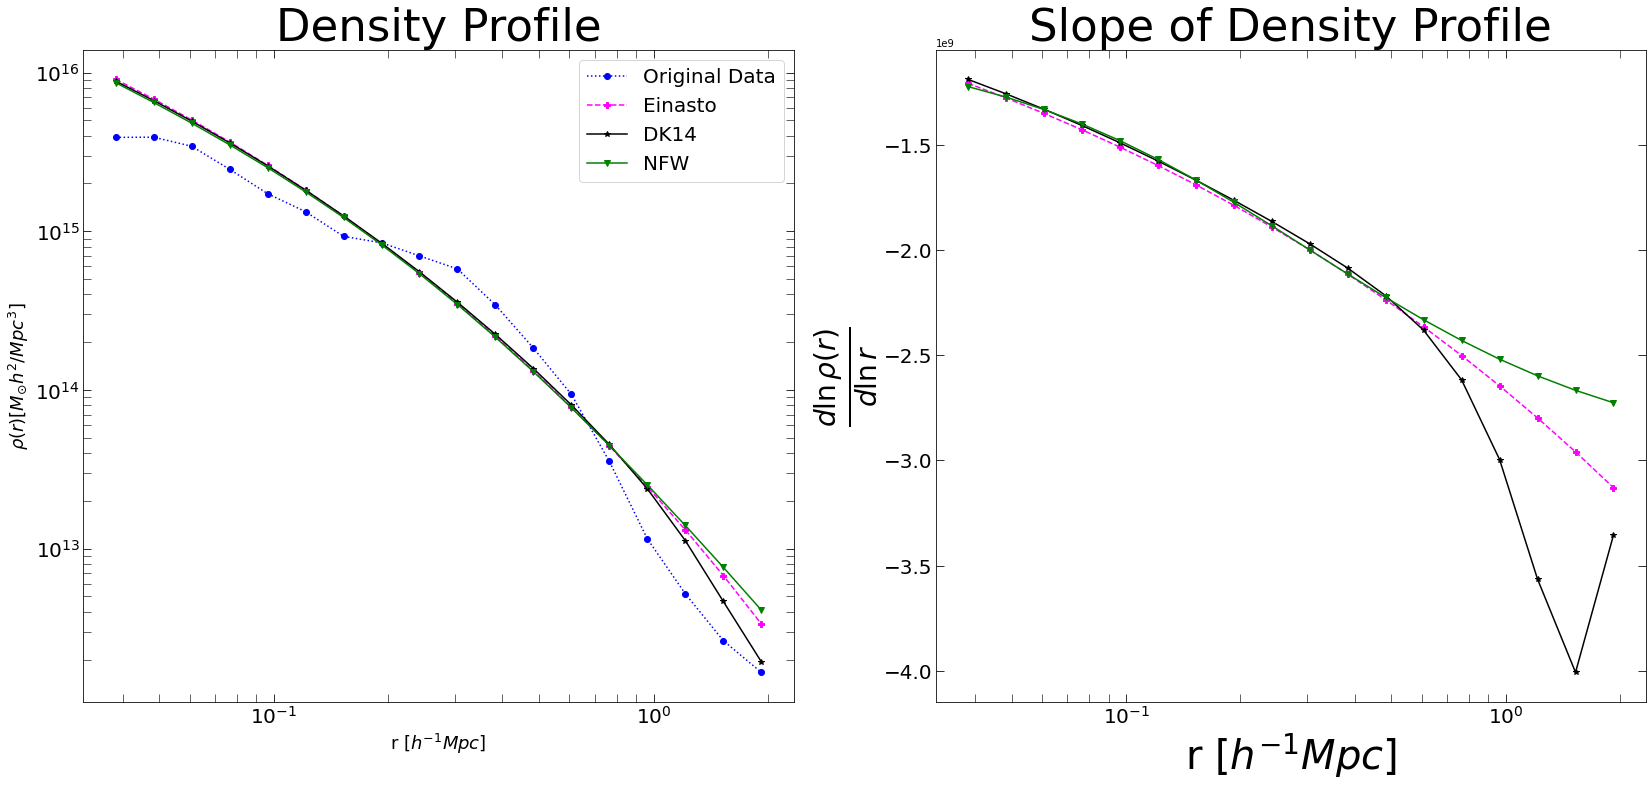

In [18]:
plt.figure(figsize = (28,12))

#Plotting the density profiles
plt.subplot(1, 2, 1)
plt.rc("axes", labelsize = 40) 
plt.title("Density Profile", fontsize = 45)
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()
plt.plot(r, rho_z_final.iloc[row, 1:]*(1+z)**3, "o", label = "Original Data", linestyle='dotted', color = "blue")
# plt.plot(r, NFW_Profile(r, z, Mvir = Mvir, Cvir = cvir, Rvir = Rvir)[2], "-", label = "NFW Function")
plt.plot(r, rho_einasto*1e9, '--', label = 'Einasto', color = "magenta", marker="P")
plt.plot(r, rho_dk14*1e9, '-', label = 'DK14', color = "black", marker="*")
plt.plot(r, rho_nfw*1e9, '-', label = 'NFW', color = "green", marker="v")
plt.tick_params(axis="both", direction="in", length=8, which = "both", labelsize=20, top = True, right = True)
plt.legend(fontsize=20)


#Plotting the slope of the density profiles
plt.subplot(1, 2, 2)
plt.rc("axes", labelsize = 40) 
plt.title("Slope of Density Profile", fontsize = 45)
plt.ylabel(r"$\frac{d\ln\rho(r)}{d\ln r}$")
plt.xlabel(r"r [$h^{-1}Mpc$]")

plt.xscale('log')
plt.plot(r, rho_einasto_der*1e9, '--', label = 'Einasto', color = "magenta", marker="P")
plt.plot(r, rho_dk14_der*1e9, '-', label = 'DK14', color = "black", marker="*")
plt.plot(r, rho_nfw_der*1e9, label = 'NFW', color = "green", marker="v");
plt.tick_params(axis="both", direction="in", length=8, which = "both", labelsize=20, top = True, right = True)
plt.show()

## Calculating peak height

In this analysis, we will be the dimensionless peak height as opposed to using mass. This is because halo density profiles have been shown to heavily depend on peak height and also allow for the comparison of mass across redshifts.


In [19]:
rockstar_final["PeakHeight"] = peaks.peakHeight(M = rockstar_final["Mvir_Msun.h"], 
                                                     z = rockstar_final["z_orig"])
rockstar_final.head()

,id,Mvir_Msun.h,z_orig,Rvir_Mpc.h,pid,rs,PeakHeight
0,4885861,1.083000e+15,0.182590,1.901225,-1,0.304903,3.548513
1,9784661,9.987000e+14,0.183402,1.849634,-1,0.466492,3.474035
2,10066287,9.211000e+14,0.183258,1.800605,-1,0.509027,3.400183
3,12390043,6.790000e+14,0.189336,1.620955,-1,0.780693,3.150932
4,5486940,6.694000e+14,0.188059,1.614432,-1,0.283228,3.137439


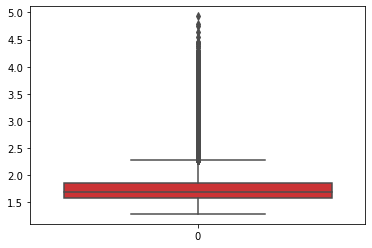

In [20]:
# Boxplot of peak height
sns.boxplot(data = rockstar_final["PeakHeight"], palette="Set1")
plt.show()

In [21]:
rockstar_final["PeakHeight"].describe()

count    1.427469e+06
mean     1.754571e+00
std      2.665895e-01
min      1.288427e+00
25%      1.586047e+00
50%      1.694026e+00
75%      1.861975e+00
max      4.930169e+00
Name: PeakHeight, dtype: float64

### Peak height bins

Here, we bin the data by peak height. We create four peak height bins.

In [22]:
#Four bins

#First bin 
v1 = rockstar_final[rockstar_final["PeakHeight"] <= 1.5]
remainder1 = pd.concat([rockstar_final, v1]).drop_duplicates(keep=False)

#Second bin 
v2 = remainder1[remainder1["PeakHeight"] <= 1.75]
remainder2 = pd.concat([remainder1, v2]).drop_duplicates(keep=False)

#Third bin 
v3 = remainder2[remainder2["PeakHeight"] <= 2.0]

#Fourth bin 
v4 = pd.concat([remainder2, v3]).drop_duplicates(keep=False)

v1 = pd.DataFrame(v1)
v2 = pd.DataFrame(v2)
v3 = pd.DataFrame(v3)
v4 = pd.DataFrame(v4)

x = ["v1", "v2", "v3", "v4"]
y = [len(v1), len(v2), len(v3), len(v4)]

### Sampling from peak height bins

We select equal samples from each bin. The sample size is the total number of observations in the smallest peak height bin.


In [23]:
seedbank.initialize(1)
rng = seedbank.numpy_rng()
frac_v1 = v1.sample(n = len(v1), random_state = 0)
frac_v2 = v2.sample(n = len(v1), random_state = 0)
frac_v3 = v3.sample(n = len(v1), random_state = 0)
frac_v4 = v4.sample(n = len(v1), random_state = 0)
frac_v4.head()

,id,Mvir_Msun.h,z_orig,Rvir_Mpc.h,pid,rs,PeakHeight
820247,28018334,6.513000e+13,0.563530,0.606208,-1,0.077629,2.221418
1385456,25146507,5.993000e+13,0.602220,0.578168,-1,0.116211,2.225276
1137696,25206119,4.012000e+13,0.631294,0.498435,-1,0.080292,2.083029
609903,32853590,8.901000e+13,0.512874,0.690500,-1,0.099577,2.312319
692190,35091696,5.944000e+13,0.539687,0.595265,-1,0.095313,2.155305


In [24]:
x2 = ["v1", "v2", "v3", "v4"]
y2 = [len(frac_v1), len(frac_v2), len(frac_v3), len(frac_v4)]

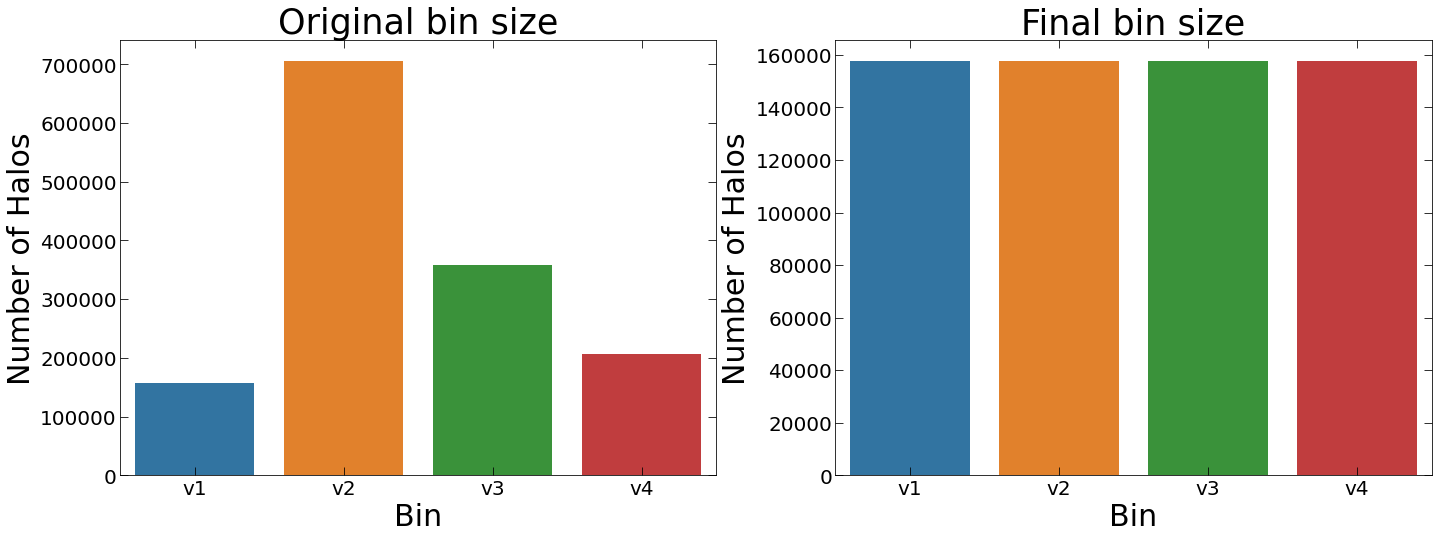

In [25]:
#Comparing plots: Visual comparison

plt.figure(figsize = (23.5,8))
plt.subplot(1, 2, 1)

sns.barplot(x = x, y = y)
plt.xlabel("Bin", fontsize = 30)
plt.ylabel("Number of Halos", fontsize = 30)
plt.title("Original bin size", fontsize = 35)
plt.tick_params(axis="both", direction="in", length=8, which = "both", labelsize=20, top = True, right = True)


###########################################################
###########################################################
plt.subplot(1, 2, 2)
sns.barplot(x = x2, y = y2)
plt.xlabel("Bin", fontsize = 30)
plt.ylabel("Number of Halos", fontsize = 30)
plt.title("Final bin size", fontsize = 35)
plt.tick_params(axis="both", direction="in", length=8, which = "both", labelsize=20, top = True, right = True)
plt.show()

## Subsetting from `rho_z` data

For the `rho_z` data set, we subset it using the indexes found in the binned `rockstar_final_new` data set. Note that the original data sets have the same indexes; so we can pool halos records from all the different data frames using either the index or the halo id. Here, we use the indexes.



In [26]:
#putting all bins together
frac_v1["Bin"] = "v1"
frac_v2["Bin"] = "v2"
frac_v3["Bin"] = "v3"
frac_v4["Bin"] = "v4"
# frac_v5["Bin"] = "v5"
rockstar_final_new = pd.concat([frac_v4, frac_v3, frac_v2, frac_v1])
rho_final_new = rho_z_final.iloc[rockstar_final_new.index, :]

print(pd.DataFrame(rockstar_final_new.index == rho_final_new.index).value_counts())

rho_final_new = pd.DataFrame(rho_final_new.reset_index().drop(columns=["index"]))
rockstar_final_new = pd.DataFrame(rockstar_final_new.reset_index().drop(columns=["index"]))

True    630548
dtype: int64


In [27]:
(rho_final_new[0]==rockstar_final_new["id"]).value_counts()

True    630548
dtype: int64

## New data frame

We combine all of them into one data set. Note that we need to take into account the fact the variables in our data have their corresponding densities at 20 different radial bins in the `rho_z` data. We repeat each row in the `rockstar_final_new` data set to much their corresponding density values in the `rho_final_new` data set. We do the same to the `radial_bins_3d` data set.


In [28]:
New_rockstar_df = rockstar_final_new.apply(lambda row: row.repeat(18), axis=0).reset_index()
print(len(New_rockstar_df))
New_rockstar_df.head()

11349864


,index,id,Mvir_Msun.h,z_orig,Rvir_Mpc.h,pid,rs,PeakHeight,Bin
0,0,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4
1,0,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4
2,0,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4
3,0,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4
4,0,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4


In [29]:
New_radial_bins_df = radial_bins_3d.append([radial_bins_3d]*(len(rho_final_new)-1), ignore_index=True)
print(len(New_radial_bins_df))
New_radial_bins_df.head()

11349864


,"r_min,","r_max,",r_mid
0,0.047547,0.059858,0.053348
1,0.059858,0.075357,0.067162
2,0.075357,0.094868,0.084552
3,0.094868,0.119432,0.106444
4,0.119432,0.150356,0.134005


In [30]:
print(len(rho_z_final)*18)
print(len(rho_final_new)*18)

25694442
11349864


Now for each row in the `rho_final_new` data set, we transpose it so that all the 20 density columns become just a single column.

In [31]:
New_rho_z = pd.DataFrame(columns=['Density'])
New_rho_z

,Density


In [32]:
for i in range(len(rho_final_new)):
    New_rho_z = New_rho_z.append(pd.DataFrame(data = list(rho_final_new.iloc[i][1:]), columns = ['Density']))

In [33]:
New_rho_z = New_rho_z.reset_index()
print(len(New_rho_z))
New_rho_z.head()

11349864


,index,Density
0,0,1.812250e+15
1,1,1.998210e+15
2,2,1.183560e+15
3,3,4.562970e+14
4,4,4.802490e+14


In [34]:
New_rockstar_df1 = New_rockstar_df.drop(['index'], axis = 1)
New_rho_z1 = New_rho_z.drop(['index'], axis = 1)

Now, we join the two data frames and then convert the densities and radial bins from comoving to physical units.

Also, there are 181900 radial bins with zero densities. This constitutes about 1.6% of the data set. These radial bins are eliminated from the data. This means there are halos whose density will be calibrated using less than 18 radial bins.


In [35]:
Final_DF = New_rockstar_df1.join(New_radial_bins_df.join(New_rho_z1))
Final_DF1 = pd.DataFrame(Final_DF)
Final_DF1["Density"] = Final_DF1["Density"]*(1+Final_DF1["z_orig"])**3 #rho_phys = rho_comov/a**3 = rho_comov*(1+z)**3
Final_DF1["r_mid_phys"] = Final_DF1["r_mid"]/(1+Final_DF1["z_orig"])
Final_DF1 = Final_DF1[Final_DF1["Density"] != 0] 
print((Final_DF1 == 0).sum(axis = 0))

print(f'Length of final data frame: {len(Final_DF1)}')
Final_DF1.head()

id             0
Mvir_Msun.h    0
z_orig         0
Rvir_Mpc.h     0
pid            0
rs             0
PeakHeight     0
Bin            0
r_min,         0
r_max,         0
r_mid          0
Density        0
r_mid_phys     0
dtype: int64
Length of final data frame: 11167964


,id,Mvir_Msun.h,z_orig,Rvir_Mpc.h,pid,rs,PeakHeight,Bin,"r_min,","r_max,",r_mid,Density,r_mid_phys
0,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4,0.047547,0.059858,0.053348,6.926866e+15,0.034120
1,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4,0.059858,0.075357,0.067162,7.637651e+15,0.042955
2,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4,0.075357,0.094868,0.084552,4.523858e+15,0.054077
3,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4,0.094868,0.119432,0.106444,1.744079e+15,0.068079
4,28018334,6.513000e+13,0.56353,0.606208,-1,0.077629,2.221418,v4,0.119432,0.150356,0.134005,1.835630e+15,0.085707


We take the log of some columns while also keeping the original values of other columns. They will all be needed separately at different points in our modeling process.


In [36]:
Final_DF_Log = Final_DF1[["PeakHeight", "Density"]]
Final_DF_Log = pd.DataFrame(Final_DF_Log)

Final_DF_Log["rmid_Rvir"] = Final_DF1["r_mid_phys"].div(Final_DF1["Rvir_Mpc.h"])

Final_DF_Log = np.log(Final_DF_Log)
Final_DF_Log["Mvir_Msun.h"] = Final_DF1["Mvir_Msun.h"]
Final_DF_Log["Rvir_Mpc.h"] = Final_DF1["Rvir_Mpc.h"]
Final_DF_Log["r_mid"] = Final_DF1["r_mid"]
Final_DF_Log["rs"] = Final_DF1["rs"]
Final_DF_Log["z_orig"] = Final_DF1["z_orig"]
Final_DF_Log["Density_orig"] = Final_DF1["Density"]
Final_DF_Log["PeakHeight_orig"] = Final_DF1["PeakHeight"]
Final_DF_Log["r_mid_phys"] = Final_DF1["r_mid_phys"]
Final_DF_Log["id"] = Final_DF1["id"]
Final_DF_Log.head()

,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,id
0,0.798146,36.474184,-2.877325,6.513000e+13,0.606208,0.053348,0.077629,0.56353,6.926866e+15,2.221418,28018334
1,0.798146,36.571866,-2.647067,6.513000e+13,0.606208,0.067162,0.077629,0.56353,7.637651e+15,2.221418,28018334
2,0.798146,36.048141,-2.416808,6.513000e+13,0.606208,0.084552,0.077629,0.56353,4.523858e+15,2.221418,28018334
3,0.798146,35.095003,-2.186550,6.513000e+13,0.606208,0.106444,0.077629,0.56353,1.744079e+15,2.221418,28018334
4,0.798146,35.146164,-1.956292,6.513000e+13,0.606208,0.134005,0.077629,0.56353,1.835630e+15,2.221418,28018334


In [37]:
# Checking for Missing Values
print(Final_DF_Log[['Density']].isnull().values.any())
print()
print(Final_DF_Log.isnull().sum())

False

PeakHeight         0
Density            0
rmid_Rvir          0
Mvir_Msun.h        0
Rvir_Mpc.h         0
r_mid              0
rs                 0
z_orig             0
Density_orig       0
PeakHeight_orig    0
id                 0
dtype: int64


We then convert the final data frame to a `.csv` file. Note that saving it in `.csv` format is actually not the only approach. For instance, we could save the data as a `.npy` file, which is usually twice smaller than the `.csv` format. However, `.csv` is more familiar to many people.


In [38]:
Final_DF_Log.to_csv("Data/Data_PH.csv", index=False)
radial_bins_3d.to_csv("Data/radial_bins.csv", index=False)
rockstar_final_new.to_csv("Data/Rockstar_PH.csv", index=False)
# len(Final_DF_Log)

## Comparing standard deviations
### Peak height

We performed a t-test to check whether the mean and variances of the data set remain data same across the various peak height bins.


In [39]:
stds = {'Bin_Std': [np.std(v1["PeakHeight"]), np.std(v2["PeakHeight"]), 
               np.std(v3["PeakHeight"]), np.std(v4["PeakHeight"])
                   ], 
        'Samp_Bin_Std': [np.std(frac_v1["PeakHeight"]), np.std(frac_v2["PeakHeight"]), 
                  np.std(frac_v3["PeakHeight"]), np.std(frac_v4["PeakHeight"])
                      ]}
stds_df = pd.DataFrame(data=stds)
stds_df

,Bin_Std,Samp_Bin_Std
0,0.052320,0.052320
1,0.066728,0.066687
2,0.070240,0.070295
3,0.255311,0.255733


In [40]:
sts.ttest_rel(stds_df["Bin_Std"], stds_df["Samp_Bin_Std"])

Ttest_relResult(statistic=-1.0270512758184778, pvalue=0.3799672033372781)

In [41]:
avgs = {'Bin_avg': [np.mean(v1["PeakHeight"]), np.mean(v2["PeakHeight"]), 
               np.mean(v3["PeakHeight"]), np.mean(v4["PeakHeight"])
                   ], 
        'Samp_Bin_avg': [np.mean(frac_v1["PeakHeight"]), np.mean(frac_v2["PeakHeight"]), 
                  np.mean(frac_v3["PeakHeight"]), np.mean(frac_v4["PeakHeight"])
                      ]}
avgs_df = pd.DataFrame(data=avgs)
avgs_df

,Bin_avg,Samp_Bin_avg
0,1.428594,1.428594
1,1.631052,1.631225
2,1.853210,1.853436
3,2.255690,2.255846


In [42]:
sts.ttest_rel(avgs_df["Bin_avg"], avgs_df["Samp_Bin_avg"])

Ttest_relResult(statistic=-2.854447122158125, pvalue=0.06487174344209488)

In [43]:
print(sts.ttest_1samp(a = frac_v1["PeakHeight"], 
                      popmean = np.mean(v1["PeakHeight"]), 
                      alternative='two-sided'))

print(sts.ttest_1samp(a = frac_v2["PeakHeight"], 
                      popmean = np.mean(v2["PeakHeight"]), 
                      alternative='two-sided'))

print(sts.ttest_1samp(a = frac_v3["PeakHeight"], 
                      popmean = np.mean(v3["PeakHeight"]), 
                      alternative='two-sided'))

print(sts.ttest_1samp(a = frac_v4["PeakHeight"], 
                      popmean = np.mean(v4["PeakHeight"]), 
                      alternative='two-sided'))

Ttest_1sampResult(statistic=0.0, pvalue=1.0)
Ttest_1sampResult(statistic=1.0290526511899376, pvalue=0.30345651307550336)
Ttest_1sampResult(statistic=1.2770026975925728, pvalue=0.20160317586345797)
Ttest_1sampResult(statistic=0.24204483230387983, pvalue=0.8087457395394353)


#### DENSITY

In [44]:
rockstar_bin = pd.DataFrame(rockstar_final)

rockstar_bin["Bin_Orig"] = "v4"

rockstar_bin.loc[rockstar_bin["PeakHeight"] <= 2.0, 
                        "Bin_Orig"] = "v3"

rockstar_bin.loc[rockstar_bin["PeakHeight"] <= 1.75, 
                        "Bin_Orig"] = "v2"

rockstar_bin.loc[rockstar_bin["PeakHeight"] <= 1.5, 
                        "Bin_Orig"] = "v1"

rockstar_bin.groupby(["Bin_Orig"]).count()

,id,Mvir_Msun.h,z_orig,Rvir_Mpc.h,pid,rs,PeakHeight
Bin_Orig,,,,,,,
v1,157637,157637,157637,157637,157637,157637,157637
v2,705413,705413,705413,705413,705413,705413,705413
v3,358584,358584,358584,358584,358584,358584,358584
v4,205835,205835,205835,205835,205835,205835,205835
